# **GoogLeNet (Inception) from scratch using Pytorch**
* https://www.kaggle.com/code/ivankunyankin/googlenet-inception-from-scratch-using-pytorch

### **1. Import Labraries**

In [ ]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

torch.manual_seed(17)

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])

### **2. Download Data from Kaggle**

In [ ]:
{"username":"trnxunkhanh","key":"eb828593f1426c62d329772657dfa85b"}
os.environ['KAGGLE_USERNAME'] = 'trnxunkhanh'
os.environ['KAGGLE_KEY'] = 'eb828593f1426c62d329772657dfa85b'

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download akash2sharma/tiny-imagenet --unzip

 99% 472M/474M [00:05<00:00, 82.8MB/s]
100% 474M/474M [00:05<00:00, 95.5MB/s]


In [ ]:
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform = transform)

In [ ]:
print(len(dataset))

100000


##### **2.1 Split the data**

In [ ]:
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [80000, 10000, 10000])

In [ ]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size = batch_size,
                          shuffle = True, num_workers = 4)
val_loader = DataLoader(val_data, batch_size = batch_size,
                        shuffle = True, num_workers = 4)
test_loader = DataLoader(test_data, batch_size = batch_size,
                         shuffle = True, num_workers = 4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Để tăng tốc quá trình huấn luyện, chúng ta sẽ sử dụng thuộc tính tùy chọn `num_workers` của lớp `DataLoader`.

Thuộc tính `num_workers` cho *instance data loader* biết có bao nhiêu quy trình con cần sử dụng để tải dữ liệu. Theo mặc định, giá trị `num_workers` được đặt bằng 0 và giá trị bằng 0 cũng được đặt cho data loader bên trong tiến trình chính.

Điều này có nghĩa là quá trình huấn luyện sẽ hoạt động tuần tự bên trong tiến trình chính. Sau đó, một batch được dùng trong quá trình huấn luyện và sẽ cần thêm một batch nữa, do đó ta sẽ lấy dữ liệu batch từ ổ đĩa

Bây giờ, nếu chúng ta có tiến trình worker, chúng ta có thể tận dụng thực tế là máy của chúng ta có nhiều lõi (cores). Điều này có nghĩa là batch tiếp theo đã có thể được load và sẵn sàng hoạt động vào thời điểm tiến trình chính sẵn sàng cho một batch khác. Đây chính là nơi bắt nguồn cho việc tăng tốc độ. Các batch được load bằng các tiến trình worker bổ sung và được xếp hàng đợi trong bộ nhớ.

##### **2.2 Visualization Image**

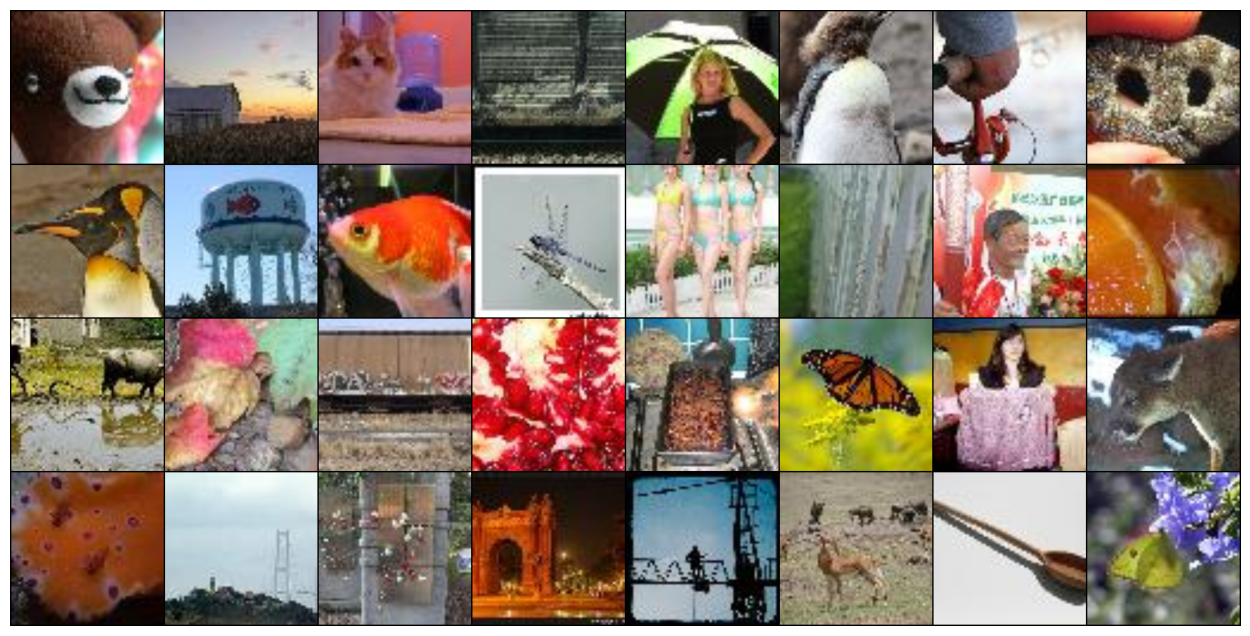

In [ ]:
for images, _ in train_loader:
  plt.figure(figsize = (16, 8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 8).permute((1, 2, 0)))
  break

### **3. Define Model**

##### **3.1 Define Modele**

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
    super(ConvBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.relu(self.bn(self.conv(x)))

In [ ]:
class InceptionBlock(nn.Module):

  def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3,
               num_5x5_red, num_5x5, num_pool_proj):
    super(InceptionBlock, self).__init__()
    self.one_by_one = ConvBlock(im_channels, num_1x1, kernel_size = 1)

    self.tree_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size = 1)
    self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size = 3, padding = 1)

    self.five_by_five_red = ConvBlock(im_channels, num_5x5_red, kernel_size = 1)
    self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size = 5, padding = 2)

    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
    self.pool_proj = ConvBlock(im_channels, num_pool_proj, kernel_size = 1)

  def forward(self, x):
    x1 = self.one_by_one(x)

    x2 = self.tree_by_three_red(x)
    x2 = self.tree_by_three(x2)

    x3 = self.five_by_five_red(x)
    x3 = self.five_by_five(x3)

    x4 = self.maxpool(x)
    x4 = self.pool_proj(x4)

    x = torch.cat([x1, x2, x3, x4], 1)
    return x

In [ ]:
class Auxiliary(nn.Module):

  def __init__(self, in_channels, num_classes):
    super(Auxiliary, self).__init__()
    self.avgpool = nn.AvgPool2d(kernel_size = 5, stride = 3)
    self.conv1x1 = ConvBlock(in_channels, 128, kernel_size = 1)

    self.fc1 = nn.Linear(2048, 1024)
    self.fc2 = nn.Linear(1024, num_classes)

    self.dropout = nn.Dropout(0.7)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.avgpool(x)
    x = self.conv1x1(x)
    x = x.reshape(x.shape[0], -1)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
class Inception(nn.Module):

  def __init__(self, in_channels = 3, use_auxiliary = True, num_classes = 1000):
    super(Inception, self).__init__()

    self.conv1 = ConvBlock(in_channels, 64, kernel_size = 7, stride = 2, padding = 3)
    self.conv2 = ConvBlock(64, 192, kernel_size = 3, stride = 1, padding = 1)

    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.avgpool = nn.AvgPool2d(kernel_size = 7, stride = 1)

    self.dropout = nn.Dropout(0.4)
    self.linear = nn.Linear(1024, num_classes)

    self.use_auxiliary = use_auxiliary
    if use_auxiliary:
      self.auxiliary4a = Auxiliary(512, num_classes)
      self.auxiliary4d = Auxiliary(528, num_classes)

    self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
    self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
    self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

  def forward(self, x):
    y = None
    z = None

    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.maxpool(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool(x)

    x = self.inception4a(x)
    if self.training and self.use_auxiliary:
      y = self.auxiliary4a(x)

    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)
    if self.training and self.use_auxiliary:
      z = self.auxiliary4d(x)

    x = self.inception4e(x)
    x = self.maxpool(x)

    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)

    x = self.linear(x)

    return x, y, z

In [ ]:
model = Inception()
model

Inception(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=1024, out_features=1000, bias=True)
  (auxiliary4a): Auxiliary(
    (avgpool): AvgPool2d(kernel_size=5, stride=3, padding=0)
    (conv1x1): ConvBlock(
      (conv): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    

##### **3.2 Define the device to use**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

##### **3.3 Move the data to the device**

In [ ]:
model.to(device)
next(model.parameters()).is_cuda

True

##### **3.4 Define everything we need for training**


In [ ]:
epochs = 3 #50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5, verbose = True)

### **4. Training Model**

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs = 50, use_auxiliary = True):
  since = time.time()
  val_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('_' * 10)
    for phase in ['train', 'val']: # Each epoch has a training and validation phase
      if phase == 'train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set mode to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]: # iterate for data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # Zero the paremeter gradients

        with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
          if phase == 'train': # Backward + optimize onlyif in training phase
            if use_auxiliary:
              outputs, aux1, aux2 = model(inputs)
              loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)
            else:
              outputs, _, _ = model(inputs)
              loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

          if phase == 'val':
            outputs, _, _ = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)

      if phase == 'val': # Adjust learning rate based in val loss
        lr_scheduler.step(epoch_loss)

      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      # Deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_acc_history.append(epoch_acc)

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # Load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

In [ ]:
model, _ = train_model(model, {'train': train_loader, 'val': val_loader}, criterion, optimizer, epochs)

Epoch 0/2
__________
train Loss: 7.1505 Acc: 0.0934
val Loss: 3.9566 Acc: 0.1356

Epoch 1/2
__________
train Loss: 5.7789 Acc: 0.1998
val Loss: 3.3532 Acc: 0.2359

Epoch 2/2
__________
train Loss: 5.0868 Acc: 0.2798
val Loss: 2.9099 Acc: 0.3191

Training complete in 18m 42s
Best val Acc: 0.319100


In [ ]:
# https://www.kaggle.com/code/ivankunyankin/googlenet-inception-from-scratch-using-pytorch